### Levenberg-Marquardt Optimization Seeded by MAXIMA-ViT

In [27]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import fabio
import yaml

from pyFAI.geometry import Geometry
from pyFAI.geometryRefinement import GeometryRefinement
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry
from pyFAI.massif import Massif
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from skimage.feature import peak_local_max

project_root = r"C:\Users\gmurra12\Projects\MAXIMA-ViT\maxima-ViT"
sys.path.append(project_root)

from src.utils import load_model, image_to_tensor, get_calibrant, get_detector

In [2]:
CONFIG_PATH = os.path.join(project_root, 'configs/full_hires_train_cfg.yaml')
MODEL_PATH = r"C:\Users\gmurra12\Projects\MAXIMA-ViT\models\v1.6\MaxViT_v1.6_12_1_25.pth"
IMAGE_PATH = r"C:\Users\gmurra12\Downloads\0,390 Al2O3 Calibrant\0,390 Al2O3 Calibrant\pure_copper_MAXIMA_STDD_0_390_1_1_0001-01-01_00-00-00+00-00\scan_point_1.tiff"
CALIBRANT_ALIAS = 'alpha_Al2O3' 
WAVELENGTH = 0.512126e-10  # m (should be pulled from HDF5 for experiment)
DETECTOR_ALIAS = 'Eiger2Cdte_1M'

In [30]:
def visualize_results(image, initial_geo, refined_geo, calibrant):
    """
    Plots the initial guess vs the refined result overlay using 2-theta contours.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Use log scale for better visibility of faint rings
    # We add a small epsilon to avoid log(0) if there are dead pixels
    log_img = np.log1p(image)

    # --- Helper to convert Geometry to AzimuthalIntegrator ---
    def make_ai(geo):
        return AzimuthalIntegrator(
            dist=geo.dist,
            poni1=geo.poni1,
            poni2=geo.poni2,
            rot1=geo.rot1,
            rot2=geo.rot2,
            rot3=geo.rot3,
            wavelength=geo.wavelength,
            detector=geo.detector
        )

    # --- Helper to draw rings ---
    def draw_rings(ax, ai, cal):
        # 1. Calculate the 2-theta angle for every pixel in the image
        # This returns an array of the same shape as the image
        tth_array = ai.twoThetaArray()
        
        # 2. Get the theoretical 2-theta angles for the calibrant rings
        # (filter out rings that might be outside the detector area to suppress warnings)
        theoretical_rings = [r for r in cal.get_2th() if r < tth_array.max()]
        
        # 3. Draw contour lines where the pixel 2-theta equals the theoretical ring 2-theta
        ax.contour(tth_array, levels=theoretical_rings, colors='red', linewidths=0.7, alpha=0.7)

    # 1. Create Integrators
    ai_initial = make_ai(initial_geometry)
    ai_refined = make_ai(final_geometry)

    # 2. Plot Initial Guess
    ax1.imshow(log_img, cmap='inferno', origin='lower')
    ax1.set_title(f"Initial ViT Prediction")
    draw_rings(ax1, ai_initial, calibrant)

    # 3. Plot Refined Result
    ax2.imshow(log_img, cmap='inferno', origin='lower')
    ax2.set_title(f"Refined NLLS Result")
    draw_rings(ax2, ai_refined, calibrant)

    plt.tight_layout()
    plt.show()

In [4]:
with open(CONFIG_PATH, "r") as f:
        config = yaml.safe_load(f)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
image = fabio.open(IMAGE_PATH).data.astype(np.float32)
image_size = config['model'].get('image_size', 224)

tensor = image_to_tensor(image, image_size)
tensor = tensor.unsqueeze(0).to(device)

In [7]:
model = load_model(MODEL_PATH, config)
model.to(device)
model.eval()

Loading weights from: C:\Users\gmurra12\Projects\MAXIMA-ViT\models\v1.6\MaxViT_v1.6_12_1_25.pth
Creating new model architecture from config...
Successfully loaded full model state.


MaxViTModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): 

In [8]:
with torch.no_grad():
        prediction = model(tensor).cpu().numpy().flatten()

param_names = ["dist", "poni1", "poni2", "rot1", "rot2", "rot3"]
print("\n--- Initial ViT Prediction ---")
for name, val in zip(param_names, prediction):
    print(f"{name:<10}: {val:.6f}")


--- Initial ViT Prediction ---
dist      : 0.302234
poni1     : 0.142096
poni2     : 0.167038
rot1      : 0.271124
rot2      : 0.303576
rot3      : -0.126620


In [33]:
h_pixels, w_pixels = tensor.shape[2], tensor.shape[3]

PIXEL_SIZE = 75e-6 
    
center_poni1 = (h_pixels * PIXEL_SIZE) / 2.0
center_poni2 = (w_pixels * PIXEL_SIZE) / 2.0

prediction[1] = center_poni1 # Uncomment to force PONI1
prediction[2] = center_poni2 # Uncomment to force PONI2

In [34]:
calibrant = get_calibrant(CALIBRANT_ALIAS, WAVELENGTH)
detector = get_detector(DETECTOR_ALIAS)

initial_geometry = Geometry(
        dist=prediction[0],
        poni1=prediction[1],
        poni2=prediction[2],
        rot1=prediction[3],
        rot2=prediction[4],\
        rot3=prediction[5],
        wavelength=calibrant.wavelength,
        detector=detector
    )

In [39]:
peaks = peak_local_max(
    image, 
    min_distance=10, 
    threshold_rel=0.1,
    exclude_border=False
)

print(f"Found {len(peaks)} peaks.")

Found 91 peaks.


In [43]:
tth_measured = initial_geometry.tth(peaks[:, 0], peaks[:, 1])
tth_expected = np.array(calibrant.get_2th())
    
labeled_peaks = []
tolerance = 1.0

for i, tth in enumerate(tth_measured):
    diffs = np.abs(tth_expected - tth)
    ring_idx = np.argmin(diffs)
    min_diff = diffs[ring_idx]
    
    if min_diff < np.deg2rad(tolerance):
        labeled_peaks.append([peaks[i, 0], peaks[i, 1], ring_idx])

peaks = np.array(labeled_peaks)

print(f"Kept {len(peaks)} peaks.")

Kept 30 peaks.


In [44]:
refiner = GeometryRefinement(
    data=peaks,  
    dist=initial_geometry.dist,
    poni1=initial_geometry.poni1,
    poni2=initial_geometry.poni2,
    rot1=initial_geometry.rot1,
    rot2=initial_geometry.rot2,
    rot3=initial_geometry.rot3,
    pixel1=initial_geometry.detector.pixel1,
    pixel2=initial_geometry.detector.pixel2,
    splineFile=initial_geometry.detector.splineFile,
    detector=initial_geometry.detector,
    wavelength=calibrant.wavelength,
    calibrant=calibrant
)

residual_error = refiner.refine2()
print(f"Residual Error: {residual_error}")

Residual Error: 7.686116025421275e-07


In [45]:
refined_dist = refiner.dist
refined_poni1 = refiner.poni1
refined_poni2 = refiner.poni2
refined_rot1 = refiner.rot1
refined_rot2 = refiner.rot2
refined_rot3 = refiner.rot3

final_geometry = Geometry(
    dist=refined_dist,
    poni1=refined_poni1,
    poni2=refined_poni2,
    rot1=refined_rot1,
    rot2=refined_rot2,
    rot3=refined_rot3,
    wavelength=WAVELENGTH,
    detector=detector
)

In [46]:
refined_params = [refined_dist, refined_poni1, refined_poni2, refined_rot1, refined_rot2, refined_rot3]

print(f"{'Parameter':<10} | {'Initial (ViT)':<15} | {'Refined (NLLS)':<15} | {'Delta':<15}")
print("-" * 65)
for name, init, final in zip(param_names, prediction, refined_params):
    delta = abs(init - final)
    print(f"{name:<10} | {init:.6f}        | {final:.6f}        | {delta:.6f}")

Parameter  | Initial (ViT)   | Refined (NLLS)  | Delta          
-----------------------------------------------------------------
dist       | 0.302234        | 0.300344        | 0.001890
poni1      | 0.039600        | 0.017276        | 0.022324
poni2      | 0.039600        | 0.029387        | 0.010213
rot1       | 0.271124        | 0.243376        | 0.027748
rot2       | 0.303576        | 0.375345        | 0.071769
rot3       | -0.126620        | -0.126620        | 0.000000


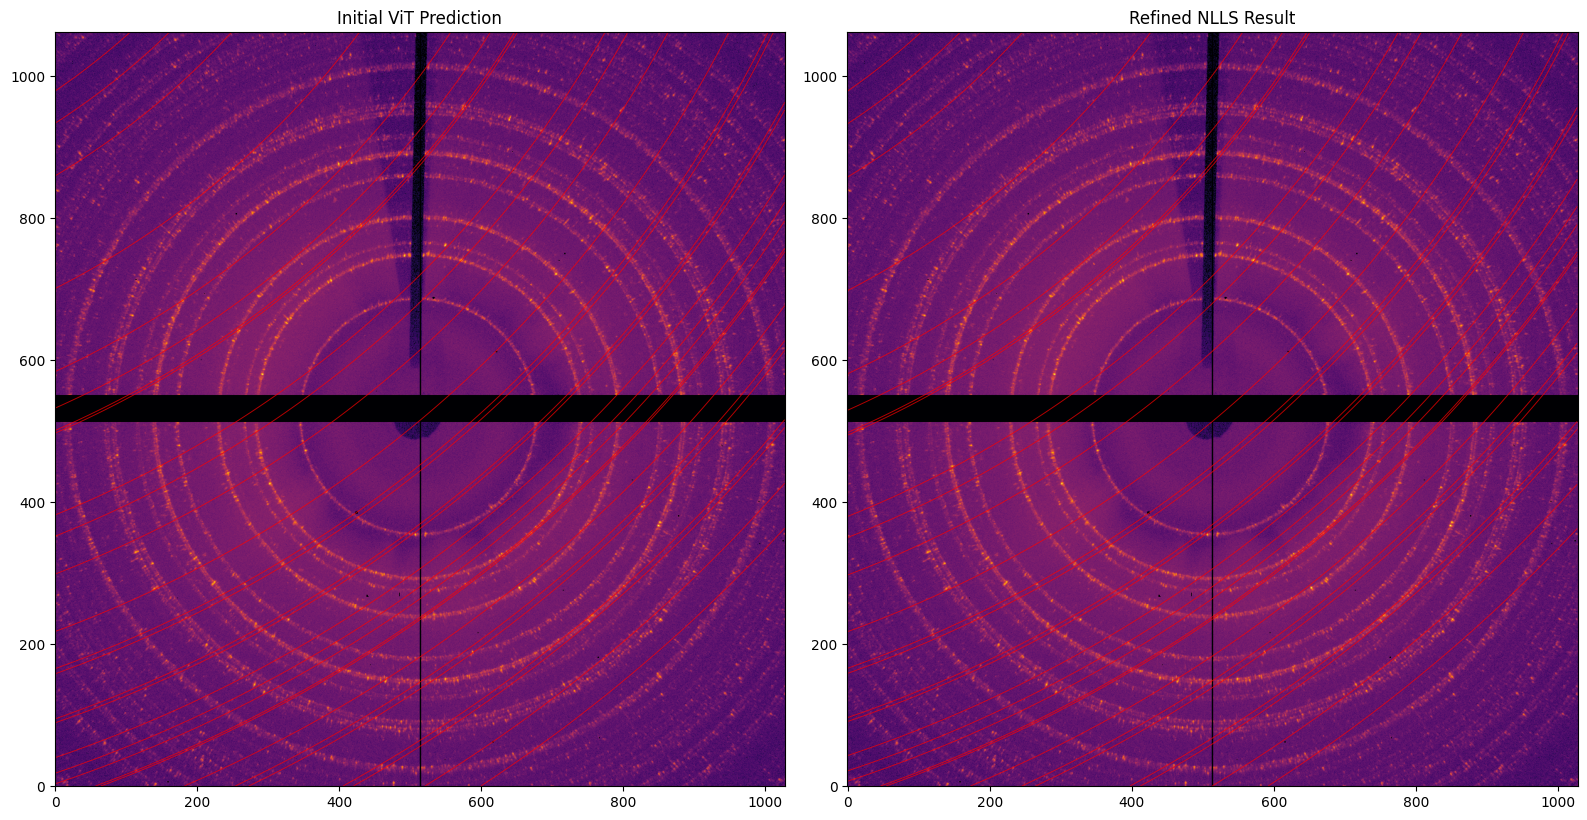

In [47]:
visualize_results(image, initial_geometry, final_geometry, calibrant)